# **Lorentzian Trading Bot**

In [7]:
import pandas as pd
import numpy as np
from tradeAlpaca import tradeAlpaca
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import pickle
import matplotlib.pyplot as plt

In [2]:
trade_inst = tradeAlpaca(keys_file="../../data/alpaca_keys.cfg")

In [3]:
data = trade_inst.get_historical_prices("BTC/USD", "2024-01-01", "2024-07-31", freq='minute')
data.head()

open        high         low  \
symbol  timestamp                                                       
BTC/USD 2024-01-01 00:00:00+00:00  42264.4130  42264.4130  42264.4130   
        2024-01-01 00:01:00+00:00  42314.7350  42315.1075  42314.7350   
        2024-01-01 00:02:00+00:00  42318.0750  42318.0750  42318.0750   
        2024-01-01 00:05:00+00:00  42390.5350  42390.5350  42390.5350   
        2024-01-01 00:07:00+00:00  42407.7215  42407.7215  42407.7215   

                                        close  volume  trade_count  vwap  
symbol  timestamp                                                         
BTC/USD 2024-01-01 00:00:00+00:00  42264.4130     0.0          0.0   0.0  
        2024-01-01 00:01:00+00:00  42315.1075     0.0          0.0   0.0  
        2024-01-01 00:02:00+00:00  42318.0750     0.0          0.0   0.0  
        2024-01-01 00:05:00+00:00  42390.5350     0.0          0.0   0.0  
        2024-01-01 00:07:00+00:00  42407.7215     0.0          0.0   0.0

### **Feature Engineering and Scaling**

In [12]:
hist_btc = data.copy()

# Create the target: 1 if future price is higher, 0 if it is lower or equal
x_minutes = 10  # Set prediction horizon
hist_btc['future_close'] = hist_btc['close'].shift(-x_minutes)
hist_btc['target'] = (hist_btc['future_close'] > hist_btc['close']).astype(int)

# Drop rows with NaN target values (at the end of the series)
hist_btc.dropna(subset=['target'], inplace=True)
# Adding lag features (prices from previous time steps)
for lag in [1, 5, 10, 20]:
    hist_btc[f'lag_{lag}_close'] = hist_btc['close'].shift(lag)

# Rolling mean (Simple Moving Averages)
hist_btc['sma_10'] = hist_btc['close'].rolling(window=10).mean()
hist_btc['sma_20'] = hist_btc['close'].rolling(window=20).mean()

# Rolling volatility (standard deviation of returns)
hist_btc['volatility_10'] = hist_btc['close'].rolling(window=10).std()

# Calculate returns (percentage change over time)
hist_btc['return_1'] = hist_btc['close'].pct_change(1)
hist_btc['return_5'] = hist_btc['close'].pct_change(5)

# Drop NaNs introduced by rolling windows
hist_btc.dropna(inplace=True)

# Now, store the valid indices after all the feature engineering steps
valid_indices = hist_btc.index  # Capture the valid indices after the second dropna()

hist_btc = hist_btc.reset_index()

# Ensure 'timestamp' is a datetime object
hist_btc['timestamp'] = pd.to_datetime(hist_btc['timestamp'])

# Datetime feature engineering
hist_btc['day_of_week'] = hist_btc['timestamp'].dt.dayofweek
hist_btc['week_of_year'] = hist_btc['timestamp'].dt.isocalendar().week
hist_btc['hour_of_day'] = hist_btc['timestamp'].dt.hour + hist_btc['timestamp'].dt.minute / 60
hist_btc['quarter'] = hist_btc['timestamp'].dt.quarter
hist_btc['month'] = hist_btc['timestamp'].dt.month
hist_btc['is_end_of_week'] = (hist_btc['day_of_week'] == 4).astype(int)

# Cyclical features: Sine and Cosine transformations
hist_btc['hour_sin'] = np.sin(2 * np.pi * hist_btc['hour_of_day'] / 24)
hist_btc['hour_cos'] = np.cos(2 * np.pi * hist_btc['hour_of_day'] / 24)
hist_btc['dow_sin'] = np.sin(2 * np.pi * hist_btc['day_of_week'] / 7)
hist_btc['dow_cos'] = np.cos(2 * np.pi * hist_btc['day_of_week'] / 7)
hist_btc['month_sin'] = np.sin(2 * np.pi * hist_btc['month'] / 12)
hist_btc['month_cos'] = np.cos(2 * np.pi * hist_btc['month'] / 12)

# DONT NEED SCALING FOR GRADIENT BOOSTING
# Select features to scale
#features_to_scale = ['close', 'lag_1_close', 'lag_5_close', 'lag_10_close', 'lag_20_close', 'sma_10', 'sma_20', 'volatility_10', 'return_1', 'return_5', 'day_of_week', 'week_of_year', 'hour_of_day', 'quarter', 'month', 'is_end_of_week', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos']
# Apply scaling
#scaler = StandardScaler()
#hist_btc[features_to_scale] = scaler.fit_transform(hist_btc[features_to_scale])

hist_btc.head()

,symbol,timestamp,open,high,low,close,volume,trade_count,vwap,future_close,...,hour_of_day,quarter,month,is_end_of_week,hour_sin,hour_cos,dow_sin,dow_cos,month_sin,month_cos
0,BTC/USD,2024-01-01 00:43:00+00:00,42401.9500,42401.9500,42401.9500,42401.9500,0.000000,0.0,0.000,42477.5245,...,0.716667,1,1,0,0.186524,0.982450,0.0,1.0,0.5,0.866025
1,BTC/USD,2024-01-01 00:44:00+00:00,42424.5490,42424.5490,42424.5490,42424.5490,0.000000,0.0,0.000,42503.6650,...,0.733333,1,1,0,0.190809,0.981627,0.0,1.0,0.5,0.866025
2,BTC/USD,2024-01-01 00:47:00+00:00,42436.5885,42436.5885,42436.5885,42436.5885,0.000000,0.0,0.000,42479.4390,...,0.783333,1,1,0,0.203642,0.979045,0.0,1.0,0.5,0.866025
3,BTC/USD,2024-01-01 00:48:00+00:00,42461.5170,42461.5170,42430.2065,42430.2065,0.000024,1.0,42461.517,42470.8490,...,0.800000,1,1,0,0.207912,0.978148,0.0,1.0,0.5,0.866025
4,BTC/USD,2024-01-01 00:49:00+00:00,42424.6120,42424.6120,42424.6120,42424.6120,0.000000,0.0,0.000,42485.1220,...,0.816667,1,1,0,0.212178,0.977231,0.0,1.0,0.5,0.866025


### **Model Training**

In [8]:
# Features (drop columns we don't need)
X = hist_btc.drop(columns=['symbol', 'timestamp', 'future_close', 'target'])
y = hist_btc['target']

# Assume X and y are already defined
# Split the data into 80% train and 20% test while maintaining the time order
train_size = int(0.8 * len(X))

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Initialize LightGBM model
model = lgb.LGBMClassifier()
# Define hyperparameters to search over
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'num_leaves': [31, 64, 128]
}

# Define time series cross-validation with 5 splits
tscv = TimeSeriesSplit(n_splits=5)

# GridSearchCV with time-series cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='accuracy', verbose=2)

# Fit on the training data
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_
print(f"Best hyperparameters: {grid_search.best_params_}")

# Predict on the test set
y_pred_test = best_model.predict(X_test)

# Evaluate the accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Set Accuracy: {test_accuracy}")

# Output the trained model and scaler (optional)
with open('lightgbm_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# with open('scaler.pkl', 'wb') as f:
#     pickle.dump(scaler, f)

# predict on whole dataset
y_pred_whole_hist = best_model.predict(X)
accuracy_whole_hist = accuracy_score(y, y_pred_whole_hist)
print(f"Overall Accuracy: {accuracy_whole_hist}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[LightGBM] [Info] Number of positive: 12717, number of negative: 12558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4631
[LightGBM] [Info] Number of data points in the train set: 25275, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503145 -> initscore=0.012582
[LightGBM] [Info] Start training from score 0.012582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

### **Backtesting**

In [22]:
# now lets take the y_pred_whole_hist and join it to the hist_btc dataframe so we can backtest a strategy
predictions = pd.DataFrame({'prediction': y_pred_whole_hist}, index=valid_indices)
backtest_data = data.copy()
backtest_data = backtest_data.join(predictions, how='right')
backtest_data.reset_index(inplace=True)
backtest_data.head()

,symbol,timestamp,open,high,low,close,volume,trade_count,vwap,prediction
0,BTC/USD,2024-01-01 00:43:00+00:00,42401.9500,42401.9500,42401.9500,42401.9500,0.000000,0.0,0.000,1
1,BTC/USD,2024-01-01 00:44:00+00:00,42424.5490,42424.5490,42424.5490,42424.5490,0.000000,0.0,0.000,1
2,BTC/USD,2024-01-01 00:47:00+00:00,42436.5885,42436.5885,42436.5885,42436.5885,0.000000,0.0,0.000,1
3,BTC/USD,2024-01-01 00:48:00+00:00,42461.5170,42461.5170,42430.2065,42430.2065,0.000024,1.0,42461.517,1
4,BTC/USD,2024-01-01 00:49:00+00:00,42424.6120,42424.6120,42424.6120,42424.6120,0.000000,0.0,0.000,1


In [26]:

# Initialize backtesting variables
initial_capital = 10000  # Starting capital
capital = initial_capital
capital_allocation_per_trade = 0.05  # 5% of the current capital per trade
position = 0  # No position initially (0 = no position, 1 = long, -1 = short)

# Track metrics
capital_history = [capital]
trade_profit = []  # Track profit/loss for each trade
positions = []  # Store the buy/sell decisions for plotting
buy_signals = []  # Timestamps of buys
sell_signals = []  # Timestamps of sells

# Loop over the data to simulate the strategy
for i in range(1, len(backtest_data)):
    current_price = backtest_data['close'].iloc[i]
    previous_prediction = backtest_data['prediction'].iloc[i-1]
    current_prediction = backtest_data['prediction'].iloc[i]

    # If transitioning from 0 to 1 (buy signal) and not already in a position
    if previous_prediction == 0 and current_prediction == 1 and position != 1:
        # Buy position
        allocation = capital_allocation_per_trade * capital
        shares_bought = allocation / current_price
        position = 1  # Set position to long (buy)
        buy_signals.append(backtest_data['timestamp'].iloc[i])
        positions.append(1)
    # If transitioning from 1 to 0 (sell signal) and currently in a long position
    elif previous_prediction == 1 and current_prediction == 0 and position == 1:
        # Sell position
        sale_value = shares_bought * current_price
        profit = sale_value - allocation
        capital += profit
        trade_profit.append(profit)
        sell_signals.append(backtest_data['timestamp'].iloc[i])
        positions.append(-1)
        position = 0  # Reset position

    # Track capital after each step
    capital_history.append(capital)

# After loop finishes, convert data to Pandas Series for plotting and analysis
capital_history = pd.Series(capital_history, index=backtest_data['timestamp'].iloc[:len(capital_history)])

# Calculate net profit
net_profit = capital - initial_capital
print(f"Net Profit: ${net_profit:.2f}")

# Calculate maximum drawdown
capital_series = pd.Series(capital_history)
cumulative_max = capital_series.cummax()
drawdown = (capital_series - cumulative_max) / cumulative_max
max_drawdown = drawdown.min()
print(f"Max Drawdown: {max_drawdown * 100:.2f}%")

# Sharpe Ratio calculation
daily_returns = capital_series.pct_change().dropna()
sharpe_ratio = np.sqrt(252) * daily_returns.mean() / daily_returns.std()
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Sortino Ratio calculation (using only negative returns)
downside_returns = daily_returns[daily_returns < 0]
sortino_ratio = np.sqrt(252) * daily_returns.mean() / downside_returns.std()
print(f"Sortino Ratio: {sortino_ratio:.2f}")

# Annualized Return (CAGR)
time_length_backtest = (backtest_data['timestamp'].iloc[-1] - backtest_data['timestamp'].iloc[0]).days / 365.25
annualized_return = (capital / initial_capital) ** (1 / time_length_backtest) - 1
print(f"Annualized Compound Return (CAGR): {annualized_return:.2%}")

Net Profit: $6103.62
Max Drawdown: -0.60%
Sharpe Ratio: 0.94
Sortino Ratio: 0.44
Annualized Compound Return (CAGR): 128.14%


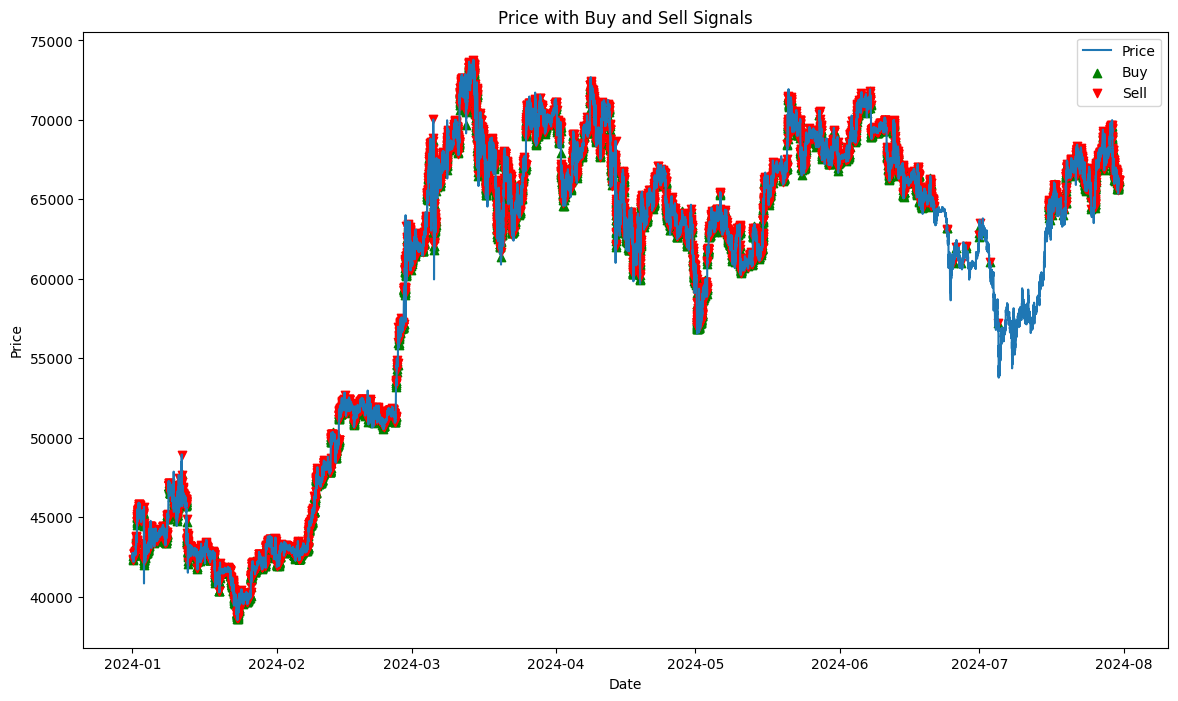

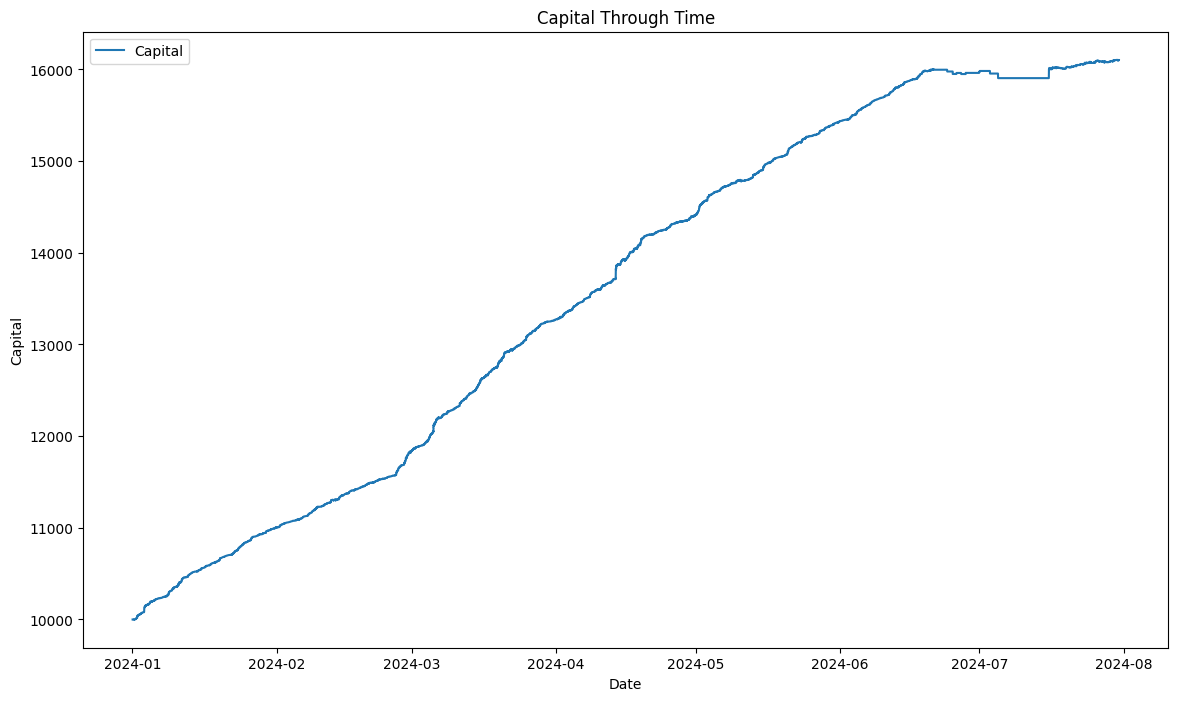

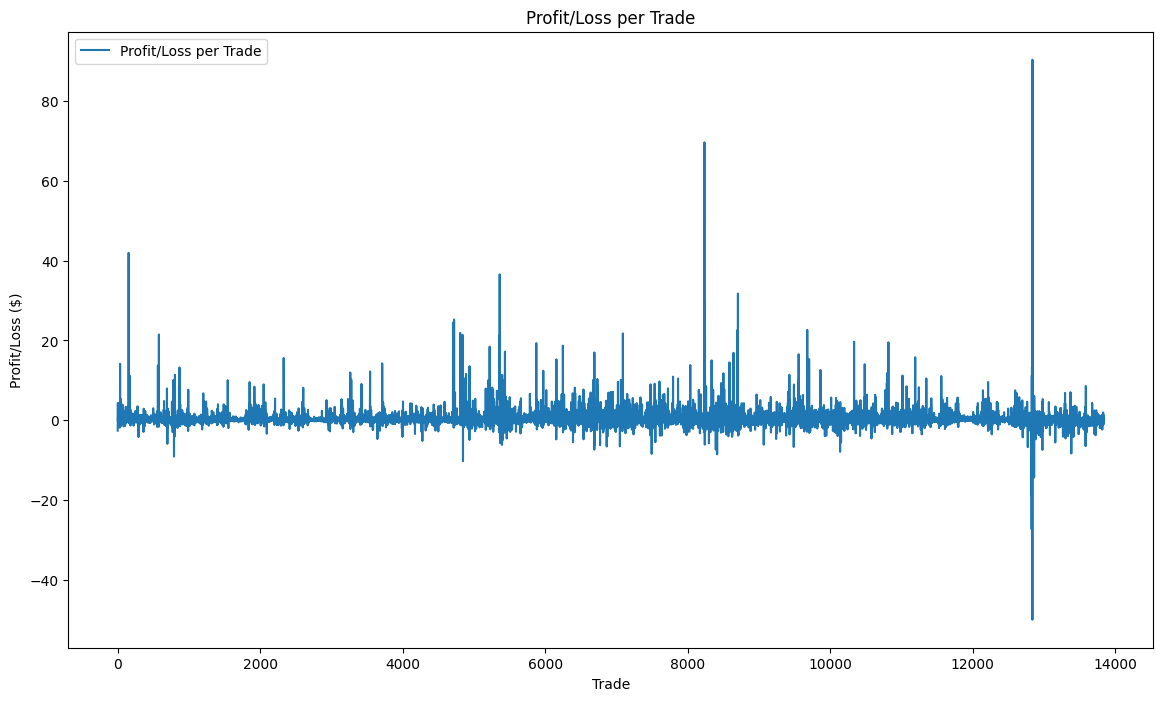

In [24]:
# Plot 1: Price with Buy/Sell Signals
plt.figure(figsize=(14, 8))
plt.plot(backtest_data['timestamp'], backtest_data['close'], label='Price')
plt.scatter(buy_signals, backtest_data.loc[backtest_data['timestamp'].isin(buy_signals), 'close'], marker='^', color='g', label='Buy', alpha=1)
plt.scatter(sell_signals, backtest_data.loc[backtest_data['timestamp'].isin(sell_signals), 'close'], marker='v', color='r', label='Sell', alpha=1)
plt.title('Price with Buy and Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot 2: Capital Through Time
plt.figure(figsize=(14, 8))
plt.plot(capital_history, label='Capital')
plt.title('Capital Through Time')
plt.xlabel('Date')
plt.ylabel('Capital')
plt.legend()
plt.show()

# Plot 3: Profit/Loss Per Trade
plt.figure(figsize=(14, 8))
plt.plot(trade_profit, label='Profit/Loss per Trade')
plt.title('Profit/Loss per Trade')
plt.xlabel('Trade')
plt.ylabel('Profit/Loss ($)')
plt.legend()
plt.show()